<a name="top"></a>
<div style="width:1000 px">


<h1>Ivenis Pita</h1>
<h3>Getting to know something about Python/Jupyter Lab</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">



## 1. Getting METARs from THREDDS

We can get the current METARS from the THREDDS test server (it's not yet available on the main thredds.ucar.edu). Head over to <a href="https://thredds-test.unidata.ucar.edu/">https://thredds-test.unidata.ucar.edu/</a> and navigate to the NOAAport products and find the files.

In [56]:
from siphon.catalog import TDSCatalog

In [57]:
cat = TDSCatalog('https://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.xml')

In [58]:
ds = cat.datasets[0]

In [59]:
ds.download()

<a name="parse"></a>
## 2. Parse the Data
MetPy can parse the METAR data for us into a dataframe that the declarative plotting inface can work with nicely.

In [60]:
from metpy.io import parse_metar_file

In [61]:
df = parse_metar_file(ds.name)

In [62]:
#df.head()

Let's take a bit of a closer look at the columns that are available to use as well.

In [63]:
#list(df.columns)

<a href="#top">Top</a>
<hr style="height:2px;">

<a name="timeseries"></a>
## 3. Time Series Request and Plot


In [206]:
from datetime import datetime, timedelta

import cartopy.crs as ccrs

from metpy.plots.declarative import *

metar_cat_url = ('http://thredds.ucar.edu/thredds/catalog/'
                 'irma/metar/catalog.xml?dataset=irma/metar/Metar_Station_Data_-_Irma_fc.cdmr')

catalog = TDSCatalog(metar_cat_url)

metar_dataset = catalog.datasets['Feature Collection']

ncss = metar_dataset.subset()

In [152]:
# Define the time range we are interested in
end_time = datetime(2017, 9, 12, 0)
start_time = end_time - timedelta(days=2)

# Build the query
query = ncss.query()
#query.lonlat_point(-80.25, 25.8)
query.lonlat_point(-155.1, 19.7)
query.time_range(start_time, end_time)
query.variables('altimeter_setting', 'temperature', 'dewpoint',
                'wind_direction', 'wind_speed')
query.accept('csv')

var=altimeter_setting&var=wind_direction&var=dewpoint&var=temperature&var=wind_speed&time_start=2017-09-10T00%3A00%3A00&time_end=2017-09-12T00%3A00%3A00&longitude=-155.1&latitude=19.7&accept=csv

In [153]:
# Get the data
data = ncss.get_data(query)

In [154]:
# Make sure we got what we asked for
print(list(data.keys()))

['time', 'station', 'latitude', 'longitude', 'altimeter_setting', 'wind_direction', 'dewpoint', 'temperature', 'wind_speed']


<a name="timeseries"></a>
## 4. Cleanup the Data

In [155]:
import pandas as pd

In [156]:
df = pd.DataFrame(data)
# Parse the date time stamps
df['time'] = pd.to_datetime(df['time'].str.decode('utf-8'), infer_datetime_format=True)
# Station names are bytes, we need to convert them to strings
df['station'] = df['station'].str.decode('utf-8')

In [161]:
#df.head()

<a name="timeseries"></a>
## 5. Make a Time Series Plot

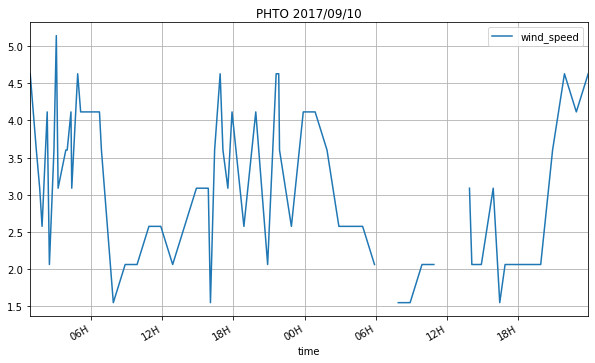

In [162]:
ax = df.plot(x='time', y='wind_speed',
             title=f"{df['station'][0]} {df['time'][0]:%Y/%m/%d}",
             grid=True,
             figsize=(10, 6))
locator = AutoDateLocator()
hoursFmt = DateFormatter('%HH')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(hoursFmt)
fig = ax.get_figure()


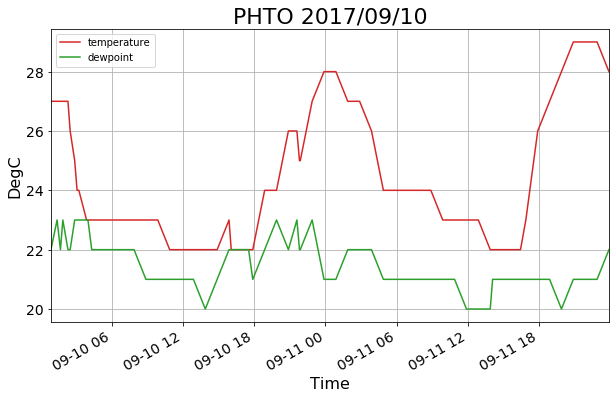

In [163]:
# Make the plot
ax = df.plot(x='time', y=['temperature', 'dewpoint'],
             color=['tab:red', 'tab:green'],
             grid=True,
             figsize=(10,6),
             fontsize=14)

# Set good labels
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('DegC', fontsize=16)
ax.set_title(f"{df['station'][0]} {df['time'][0]:%Y/%m/%d}", fontsize=22)

# Improve on the default ticking
locator = AutoDateLocator()
hoursFmt = DateFormatter('%HH')
ax.xaxis.set_major_locator(locator)
#ax.xaxis.set_major_formatter(hoursFmt)

<a href="#top">Top</a>
<hr style="height:2px;">

<a name="timeseries"></a>
## 6. Scatter plot with histograms


Create a scatter plot with histograms to its sides.



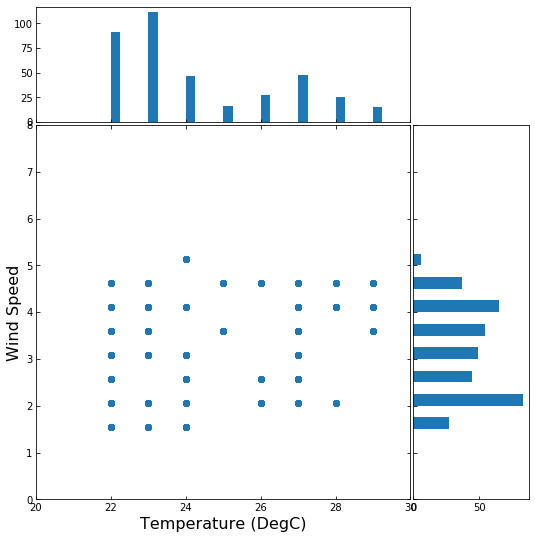

In [202]:
import numpy as np
import matplotlib.pyplot as plt


# selecting data
x = df['temperature']
xx = x[~np.isnan(x)]
y = df['wind_speed']
yy = y[~np.isnan(y)]

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(x, y)

# now determine nice limits by hand:
binwidth = 0.25
ax_scatter.set_xlim((20, 30))
ax_scatter.set_ylim((0, 8))
ax_scatter.set_xlabel('Temperature (DegC)', fontsize=16)
ax_scatter.set_ylabel('Wind Speed', fontsize=16)

#ax_scatter.set_xlim((-lim, lim))
#ax_scatter.set_ylim((-lim, lim))


binsx = np.arange(20, 30 + binwidth, binwidth)
binsy = np.arange(0, 8 + binwidth, binwidth)
ax_histx.hist(x, bins=binsx)
ax_histy.hist(y, bins=binsy, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

<a href="#top">Top</a>
<hr style="height:2px;">

<a name="timeseries"></a>
## 7. Box plots with custom fill colors


This plot illustrates how to create two types of box plots
(rectangular and notched), and how to fill them with custom
colors by accessing the properties of the artists of the
box plots. Additionally, the ``labels`` parameter is used to
provide x-tick labels for each sample.

A good general reference on boxplots and their history can be found
here: http://vita.had.co.nz/papers/boxplots.pdf



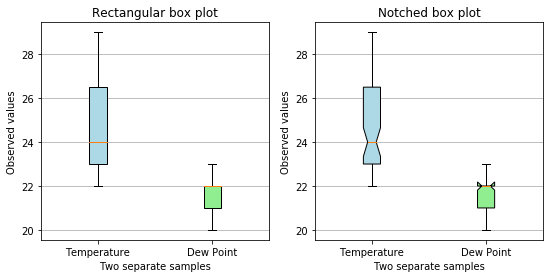

In [204]:

temp =[27., 27., 27., 27., 27., 27., 26., 25., 24., 24., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 22., 23., 23., 22., 22., 22., 22., 22., 22., 22., 24., 24., 26., 26., 25., 25., 25., 27., 28., 28., 28., 27., 27., 26., 24., 24., 24., 24., 24., 23., 23., 23., 23., 22., 22., 22., 22., 22., 23., 23., 26., 27., 28., 29., 29., 29., 28.]
dew  =[22., 23., 22., 22., 23., 22., 22., 23., 23., 23., 23., 23., 23., 23., 22., 22., 22., 22., 22., 22., 22., 22., 22., 22., 21., 21., 21., 21., 21., 20., 21., 22., 22., 22., 22., 22., 22., 22., 22., 21., 22., 23., 22., 23., 23., 22., 22., 23., 21., 21., 21., 22., 22., 22., 21., 21., 21., 21., 21., 21., 21., 21., 20., 20., 20., 21., 21., 20., 21., 21., 22.]

all_data=[temp,dew]
labels = ['Temperature', 'Dew Point']

#all_data=[temp,dew,wind_sp]
#labels = ['Temperature', 'Dew Point', 'Wind Speed']


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

# rectangular box plot
bplot1 = axes[0].boxplot(all_data,
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels)  # will be used to label x-ticks
axes[0].set_title('Rectangular box plot')

# notch shape box plot
bplot2 = axes[1].boxplot(all_data,
                         notch=True,  # notch shape
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels)  # will be used to label x-ticks
axes[1].set_title('Notched box plot')

# fill with colors
colors = ['lightblue', 'lightgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xlabel('Two separate samples')
    ax.set_ylabel('Observed values')

plt.show()